In [1]:
import os
import re
import warnings
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import pandexo.engine.justdoit as jdi

warnings.filterwarnings("ignore")

# Global parameters
AGES = ["0.0", "2.0"]
N_TRANSITS_LIST = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
N_SAMPLES = 1000 

BASE_DIR = os.getcwd()
PARENT_DIR = os.path.dirname(BASE_DIR)
CONTAMINATION_DIR = os.path.join(PARENT_DIR, "stellar_contamination")

CONTAMINATION_FILES = [
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.01_ffac0.08.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.01_ffac0.54.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.01_ffac0.70.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.08_ffac0.08.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.08_ffac0.54.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.08_ffac0.70.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.26_ffac0.08.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.26_ffac0.54.txt"
    ),
    os.path.join(
        CONTAMINATION_DIR, "TRAPPIST-1_contam_fspot0.26_ffac0.70.txt"
    ),
]

N_JOBS = -1  # Use all available cores


def run_pandexo_no_contam(age, n_transits):
    """
    Run PandExo for the base spectrum without contamination.
    """
    base_spectrum_path = os.path.join(BASE_DIR, f"E_{age}Ga.txt")
    if not os.path.isfile(base_spectrum_path):
        print(f"[WARNING] File not found: {base_spectrum_path}")
        return None, None, None

    exo_dict = jdi.load_exo_dict()
    exo_dict["observation"].update({
        "sat_level": 80,
        "sat_unit": "%",
        "R": None,
        "baseline_unit": "total",
        "baseline": 0.9535 * 3 * 60 * 60,
        "noise_floor": 0,
        "noccultations": n_transits,
    })
    exo_dict["star"].update({
        "type": "phoenix",
        "mag": 11.354,
        "ref_wave": 1.25,
        "temp": 2566,
        "metal": 0.0,
        "logg": 5.2396,
    })
    exo_dict["planet"].update({
        "type": "user",
        "w_unit": "um",
        "f_unit": "rp^2/r*^2",
        "transit_duration": 0.9535 * 60 * 60,
        "td_unit": "s",
        "exopath": base_spectrum_path,
    })

    inst_dict = jdi.load_mode_dict("NIRSpec Prism")
    inst_dict["configuration"]["detector"].update({
        "subarray": "sub512",
        "ngroup": 6,
    })

    try:
        results = jdi.run_pandexo(exo_dict, inst_dict)
        # Skip first 18 points as in original code
        waves = results["FinalSpectrum"]["wave"][18:]
        spectrum = results["FinalSpectrum"]["spectrum"][18:]
        errors = results["FinalSpectrum"]["error_w_floor"][18:]
        return waves, spectrum, errors
    except Exception as e:
        print(f"[ERROR] PandExo failed: {str(e)}")
        return None, None, None


def run_case(age, n_transits):
    """
    Process all contamination cases, including the uncontaminated case.
    """
    print(f"\n[STARTING] Age: {age} Ga | Transits: {n_transits}")

    waves, spectrum, errors = run_pandexo_no_contam(age, n_transits)
    if waves is None:
        return

    n_wave = len(waves)
    print(f"[INFO] Spectral points: {n_wave}")

    # Cases: None = uncontaminated; others = contamination files
    all_cases = [None] + CONTAMINATION_FILES

    for case in all_cases:
        if case is None:
            f_spot, f_fac = 0.00, 0.00
            factor = np.ones(n_wave)
            print("\n[PROCESSING] Base case without contamination")
        else:
            fname = os.path.basename(case)
            match = re.match(
                r"TRAPPIST-1_contam_fspot(\d+\.\d+)_ffac(\d+\.\d+).txt", fname
            )
            if not match:
                continue
            f_spot, f_fac = map(float, match.groups())
            try:
                contam_data = np.loadtxt(case)
                factor = contam_data[:, 1] if contam_data.ndim == 2 else contam_data
                if len(factor) != n_wave:
                    print(f"[ERROR] Incorrect dimensions in {fname}")
                    continue
            except Exception as e:
                print(f"[ERROR] Failed to load {fname}: {str(e)}")
                continue
            print(f"\n[PROCESSING] {fname}")

        contaminated_spectrum = spectrum * factor
        samples = np.random.normal(
            loc=contaminated_spectrum,
            scale=errors,
            size=(N_SAMPLES, n_wave)
        )

        output_name = (
            f"E_{age}Ga_fspot{f_spot:.2f}_ffac{f_fac:.2f}_{n_transits}transits.csv"
        )
        pd.DataFrame(samples, columns=waves).to_csv(output_name, index=False)
        print(f"[SAVED] {output_name}")

print("=== INITIAL VALIDATION ===")
print(f"Contamination directory: {CONTAMINATION_DIR}")
for cf in CONTAMINATION_FILES:
    exists_msg = "EXISTS" if os.path.exists(cf) else "MISSING"
    print(f"File {exists_msg}: {os.path.basename(cf)}")

print("\n=== STARTING SIMULATIONS ===")
tasks = [(age, nt) for age in AGES for nt in N_TRANSITS_LIST]
Parallel(n_jobs=N_JOBS)(delayed(run_case)(age, nt) for age, nt in tasks)

print("\n=== SIMULATIONS COMPLETED ===")


=== INITIAL VALIDATION ===
Contamination directory: c:\Proyectos\Astro\MultiREx-public\examples\papers\DZF-MLBiosignatureClassification\stellar_contamination
File EXISTS: TRAPPIST-1_contam_fspot0.01_ffac0.08.txt
File EXISTS: TRAPPIST-1_contam_fspot0.01_ffac0.54.txt
File EXISTS: TRAPPIST-1_contam_fspot0.01_ffac0.70.txt
File EXISTS: TRAPPIST-1_contam_fspot0.08_ffac0.08.txt
File EXISTS: TRAPPIST-1_contam_fspot0.08_ffac0.54.txt
File EXISTS: TRAPPIST-1_contam_fspot0.08_ffac0.70.txt
File EXISTS: TRAPPIST-1_contam_fspot0.26_ffac0.08.txt
File EXISTS: TRAPPIST-1_contam_fspot0.26_ffac0.54.txt
File EXISTS: TRAPPIST-1_contam_fspot0.26_ffac0.70.txt

=== STARTING SIMULATIONS ===

=== SIMULATIONS COMPLETED ===


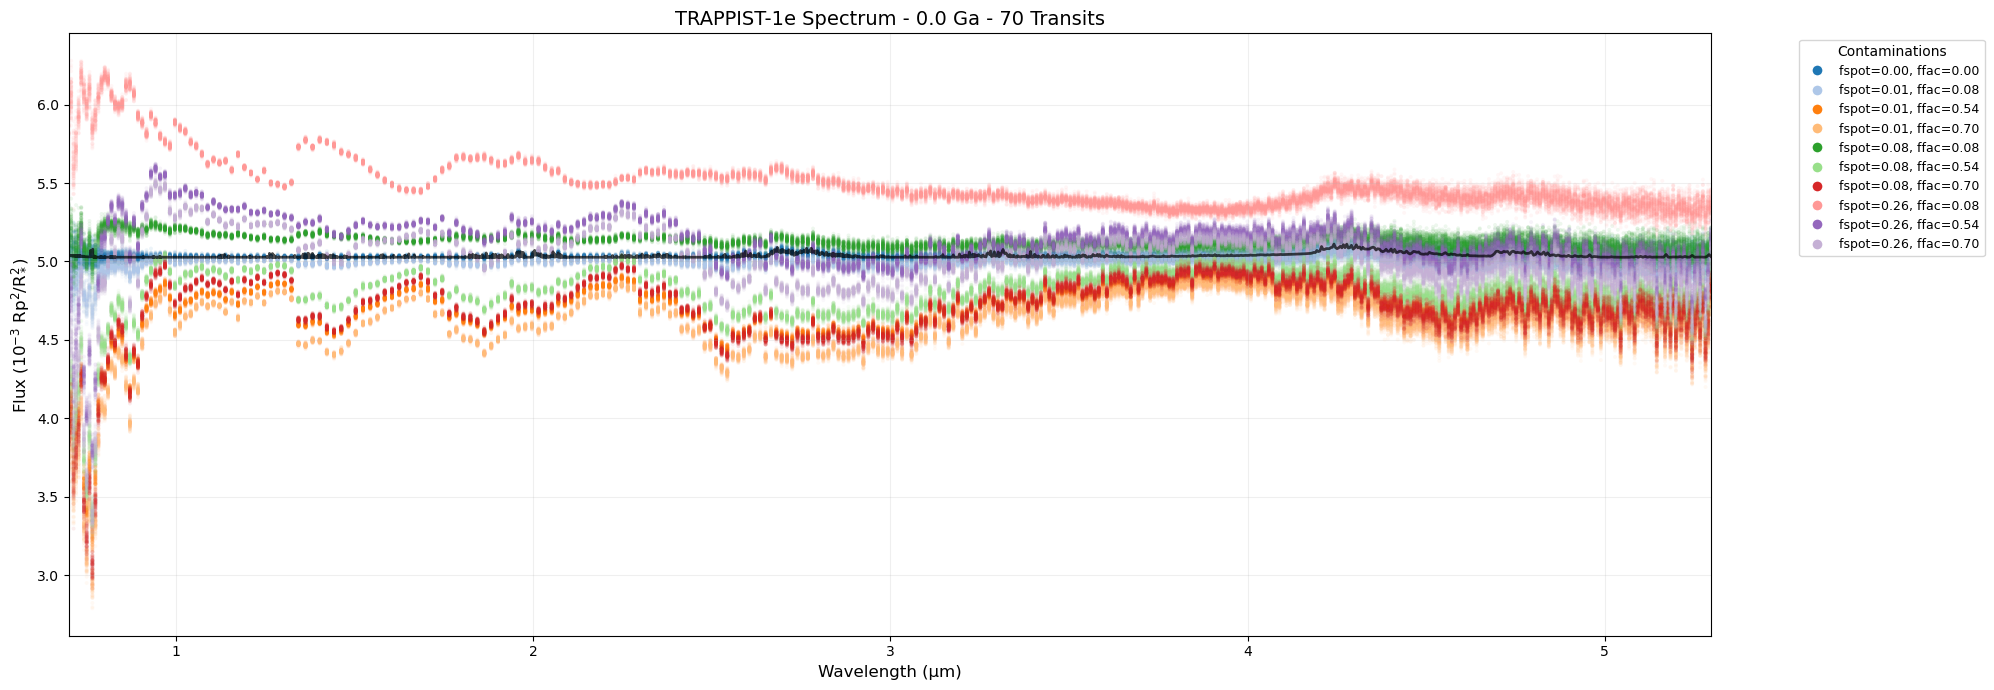

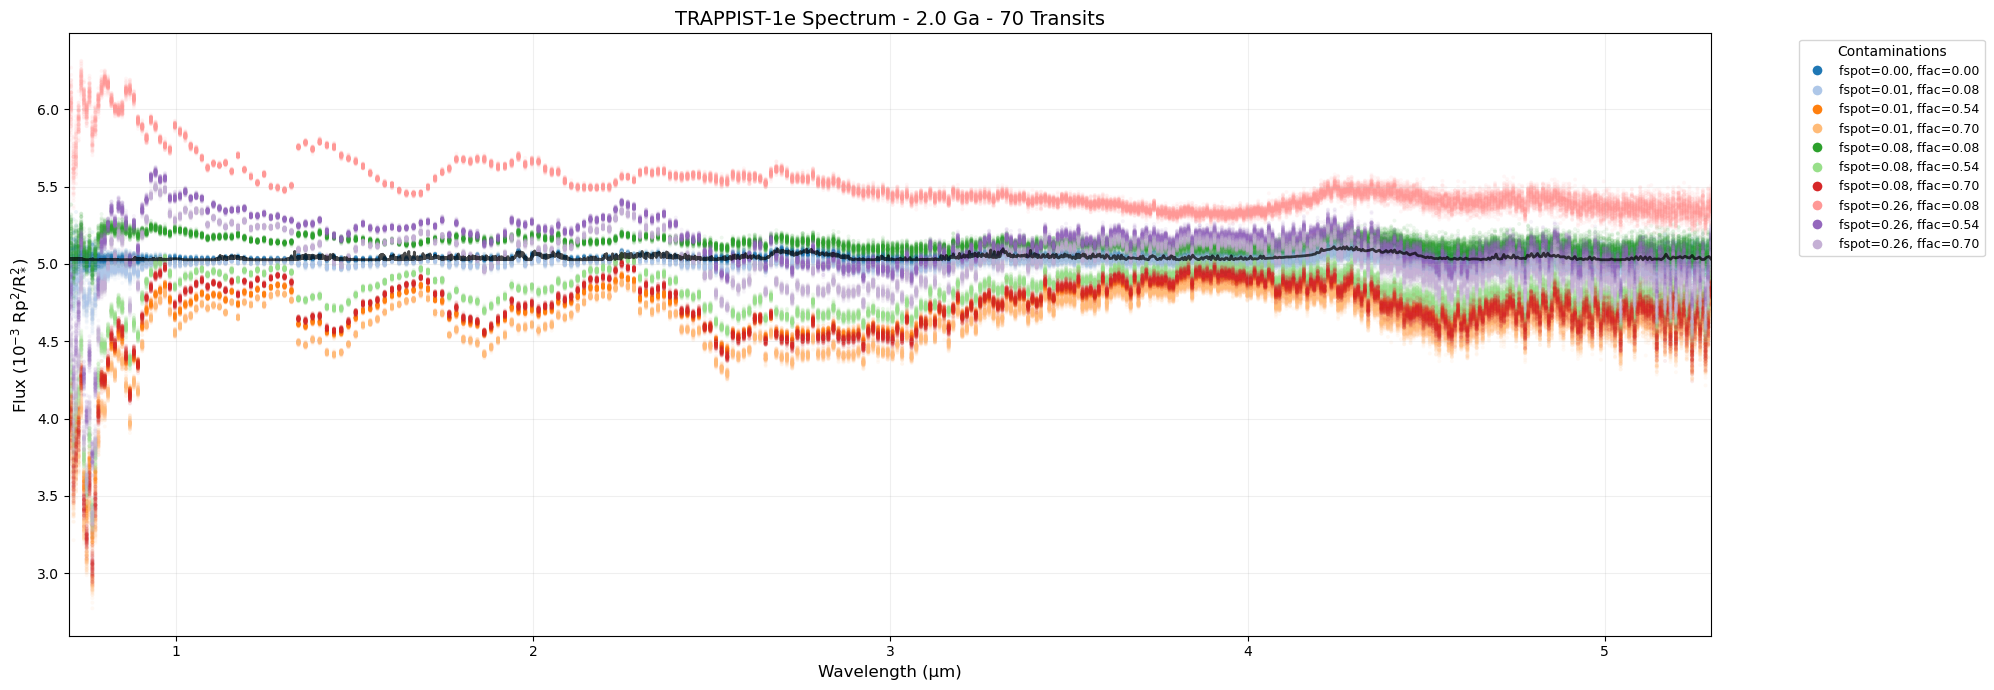

In [2]:
"""
Spectrum plotting utility with contamination visualization
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from matplotlib.cm import get_cmap


def plot_spectra_with_contaminations(ages, n_transits=100):
    """Plot spectral data with different contamination scenarios.
    
    Args:
        ages (list): List of age strings to process (e.g., ["0.0", "2.0"])
        n_transits (int): Number of transits to visualize (default: 100)
    """
    # Color configuration
    cmap = get_cmap('tab20')  # 20-color discrete palette
    color_map = {}  # Contamination-to-color mapping

    for age in ages:
        # Load base spectrum
        base_file = f'E_{age}Ga.txt'
        try:
            spec = pd.read_csv(base_file, sep=' ', header=None)
            base_wavelength = spec[0]
            base_flux = spec[1] * 1e3
        except FileNotFoundError:
            print(f"Base file {base_file} not found!")
            continue

        # Find all contamination files for this age
        file_pattern = re.compile(
            rf"E_{age}Ga_fspot(\d+\.\d+)_ffac(\d+\.\d+)_{n_transits}transits\.csv"
        )
        contamination_files = [f for f in os.listdir() if file_pattern.match(f)]
        
        # Create figure
        plt.figure(figsize=(20, 7))
        plt.plot(
            base_wavelength,
            base_flux,
            label='Base spectrum',
            alpha=0.7,
            lw=2,
            color='black'
        )

        # Plot each contamination scenario
        for idx, contam_file in enumerate(sorted(contamination_files)):
            # Extract contamination parameters
            match = file_pattern.match(contam_file)
            f_spot = match.group(1)
            f_fac = match.group(2)
            contam_key = f"fspot={f_spot}, ffac={f_fac}"
            
            # Assign unique color
            if contam_key not in color_map:
                color_map[contam_key] = cmap(idx % cmap.N)
            
            # Read data and plot
            df = pd.read_csv(contam_file)
            wavelengths = df.columns.astype(float).values
            color = color_map[contam_key]
            
            # Plot all realizations
            for i in range(100):
                plt.scatter(
                    wavelengths,
                    df.iloc[i].values * 1e3,
                    alpha=0.08,
                    color=color,
                    s=8,
                    marker='o',
                    edgecolors='none'
                )

        # Plot adjustments
        plt.xlim(min(wavelengths), max(wavelengths))
        plt.xlabel('Wavelength (µm)', fontsize=12)
        plt.ylabel('Flux (10$^{-3}$ Rp$^2$/R$_*^2$)', fontsize=12)
        plt.title(
            f'TRAPPIST-1e Spectrum - {age} Ga - {n_transits} Transits',
            fontsize=14
        )
        
        # Create custom legend
        legend_elements = [
            plt.Line2D(
                [0], [0],
                marker='o',
                color='w',
                label=contam,
                markerfacecolor=color,
                markersize=8
            ) for contam, color in color_map.items()
        ]
        
        plt.legend(
            handles=legend_elements,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title='Contaminations',
            fontsize=9
        )
        
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()



sample_ages = ["0.0", "2.0"]
plot_spectra_with_contaminations(sample_ages, n_transits=70)